Import Libraries

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn import ensemble
import math
import pickle
import shap

%matplotlib inline

Load Data

In [6]:
historical_data_doordash=pd.read_csv('historical_data.csv')
hist_data=historical_data_doordash

Calculating the size of the dataset..

In [7]:
len(hist_data)

197428

# Data Cleaning

Let's look at missing row values first

In [8]:
for col in hist_data.columns:
    null=hist_data[hist_data[col].isnull()]
    print col,len(null)

market_id 987
created_at 0
actual_delivery_time 7
store_id 0
store_primary_category 4760
order_protocol 995
total_items 0
subtotal 0
num_distinct_items 0
min_item_price 0
max_item_price 0
total_onshift_dashers 16262
total_busy_dashers 16262
total_outstanding_orders 16262
estimated_order_place_duration 0
estimated_store_to_consumer_driving_duration 526


There are only 7 rows which don't have an actual delivery time. Discarding these rows( as these don't have a training target value)

Replacing the missing row values for the number of dashers using market_id and vice versa. Discarding rows which have both total_onshift_dashers and market_id missing values missing. There are only 68 such rows, a tiny fraction. 

In [9]:
hist_data=hist_data.dropna(subset=['actual_delivery_time'])
hist_data=hist_data.dropna(subset=['market_id','total_onshift_dashers'],how='all')

We use a nearest neighbor approach to determine market_id for missing rows. Since market_id reflects the local region and hence the size of the local population, it is reasonable to use total_onshift_dashers and total_busy_dashers as the features to calculate Euclidean distance for determining the nearest neighbor. We group the data by market_id and determine the median total_onshift_dashers and total_busy_dashers for all markets and then find out the market_id closest to the current missing row using the distance metric. 

In [10]:
dashers_by_market=hist_data.groupby(['market_id'],as_index=False).agg({'total_onshift_dashers':'median','total_busy_dashers':'median'})
dashers_by_market

,market_id,total_busy_dashers,total_onshift_dashers
0,1.0,18.0,19.0
1,2.0,53.0,55.0
2,3.0,13.0,15.0
3,4.0,57.0,60.0
4,5.0,16.0,20.0
5,6.0,35.0,36.0


Calculating missing market_id values

In [11]:
dashers_by_market_np=dashers_by_market.values
number_of_markets=len(dashers_by_market_np)
def replace_missing_market_id(x):
    if np.isnan(x[0]):
        distance=np.zeros(number_of_markets)
        for i in range(number_of_markets):
            distance[i]=math.sqrt((dashers_by_market_np[i][0]-x[11])*(dashers_by_market_np[i][0]-x[11])+(dashers_by_market_np[i][1]-x[12])*(dashers_by_market_np[i][1]-x[12]))
        return np.argmin(distance)+1   
    else:
        return x[0]

In [12]:
hist_data['market_id']=hist_data.apply(replace_missing_market_id,axis=1)


We are going to define some time-based features now: time of the day represented as a float number, hour of the day as an integer, day of the week as an integer, a binary weekday/weekend feature and a binary peak hours/non-peak hours feature. By looking at mean delivery times for each hour, 6 hours were isolated as peak hours. 

In [13]:
def calculate_delivery_time(x):
    created_at=datetime.strptime(x[1], '%Y-%m-%d %H:%M:%S')
    actual_delivery_time=datetime.strptime(x[2], '%Y-%m-%d %H:%M:%S')
    delta=actual_delivery_time-created_at
    return delta.total_seconds()

def calculate_time(x):
    created_at=datetime.strptime(x[1], '%Y-%m-%d %H:%M:%S')
    return float(created_at.hour)+(float(created_at.minute)/60)

def calculate_hour(x):
    created_at=datetime.strptime(x[1], '%Y-%m-%d %H:%M:%S')
    return int(created_at.hour)

def calculate_day(x):
    created_at=datetime.strptime(x[1], '%Y-%m-%d %H:%M:%S')
    return created_at.weekday()

def weekend(x):
    created_at=datetime.strptime(x[1], '%Y-%m-%d %H:%M:%S')
    if created_at.weekday() in [1,2,3,4]:
        return 0
    else:
        return 1
    
def peak_hours(x):
    created_at=datetime.strptime(x[1], '%Y-%m-%d %H:%M:%S')
    if created_at.hour in [1,2,3,14,15,16]:
        return 1
    else:
        return 0    

def map_store_category_label(x):
    return store_category_dictionary[x[4]]

hist_data['delivery_time']=hist_data.apply(calculate_delivery_time,axis=1)
hist_data['time_of_day']=hist_data.apply(calculate_time,axis=1)
hist_data['day']=hist_data.apply(calculate_day,axis=1)
hist_data['hour']=hist_data.apply(calculate_hour,axis=1)
hist_data['weekend']=hist_data.apply(weekend,axis=1)
hist_data['peak_hours']=hist_data.apply(peak_hours,axis=1)





In [14]:
mean_market_features_by_market_weekend_peak=hist_data.groupby(['market_id','weekend','peak_hours'],as_index=False).agg({'total_onshift_dashers':'mean','total_busy_dashers':'mean','total_outstanding_orders':'mean','estimated_store_to_consumer_driving_duration':'mean'})
mean_market_features_by_market_weekend_peak=mean_market_features_by_market_weekend_peak.rename(index=str,columns={"total_onshift_dashers": "market_mean_onshift_dashers","total_busy_dashers": "market_mean_busy_dashers","total_outstanding_orders": "market_mean_outstanding_orders",'estimated_store_to_consumer_driving_duration':'market_mean_driving_duration'})


All rows have market_id values. We now do a inner join between historical data and the median_market_features_by_market_weekend_peak table. We are replacing missing dasher information by answering: How many dashers do you typically see in this market on a weekday/weekend at a peak/non-peak hour? We do the same for missing total_outstanding_orders and estimated_store_to_consumer_driving_duration.

We can also potentially use median market feature values as input to the learning algorithm later on.

In [15]:
hist_data=pd.merge(hist_data, mean_market_features_by_market_weekend_peak, on=['market_id','weekend','peak_hours'])

In [17]:
def replace_missing_total_onshift_dashers(x):
    if np.isnan(x['total_onshift_dashers']):
        return int(x['market_mean_onshift_dashers'])
    else:
        return x['total_onshift_dashers']

def replace_missing_total_busy_dashers(x):
    if np.isnan(x['total_busy_dashers']):
        return int(x['market_mean_busy_dashers'])
    else:
        return x['total_busy_dashers']
    
def replace_missing_total_outstanding_orders(x):
    if np.isnan(x['total_outstanding_orders']):
        return int(x['market_mean_outstanding_orders'])    
    else:
        return x['total_outstanding_orders']
    
def replace_missing_driving_duration(x):
    if np.isnan(x['estimated_store_to_consumer_driving_duration']):
        return int(x['market_mean_driving_duration'])   
    else:
        return x['estimated_store_to_consumer_driving_duration']    

In [18]:
hist_data['total_onshift_dashers']=hist_data.apply(replace_missing_total_onshift_dashers,axis=1)
hist_data['total_busy_dashers']=hist_data.apply(replace_missing_total_busy_dashers,axis=1)
hist_data['total_outstanding_orders']=hist_data.apply(replace_missing_total_outstanding_orders,axis=1)
hist_data['estimated_store_to_consumer_driving_duration']=hist_data.apply(replace_missing_total_outstanding_orders,axis=1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1170184d0>,
      dtype=object)

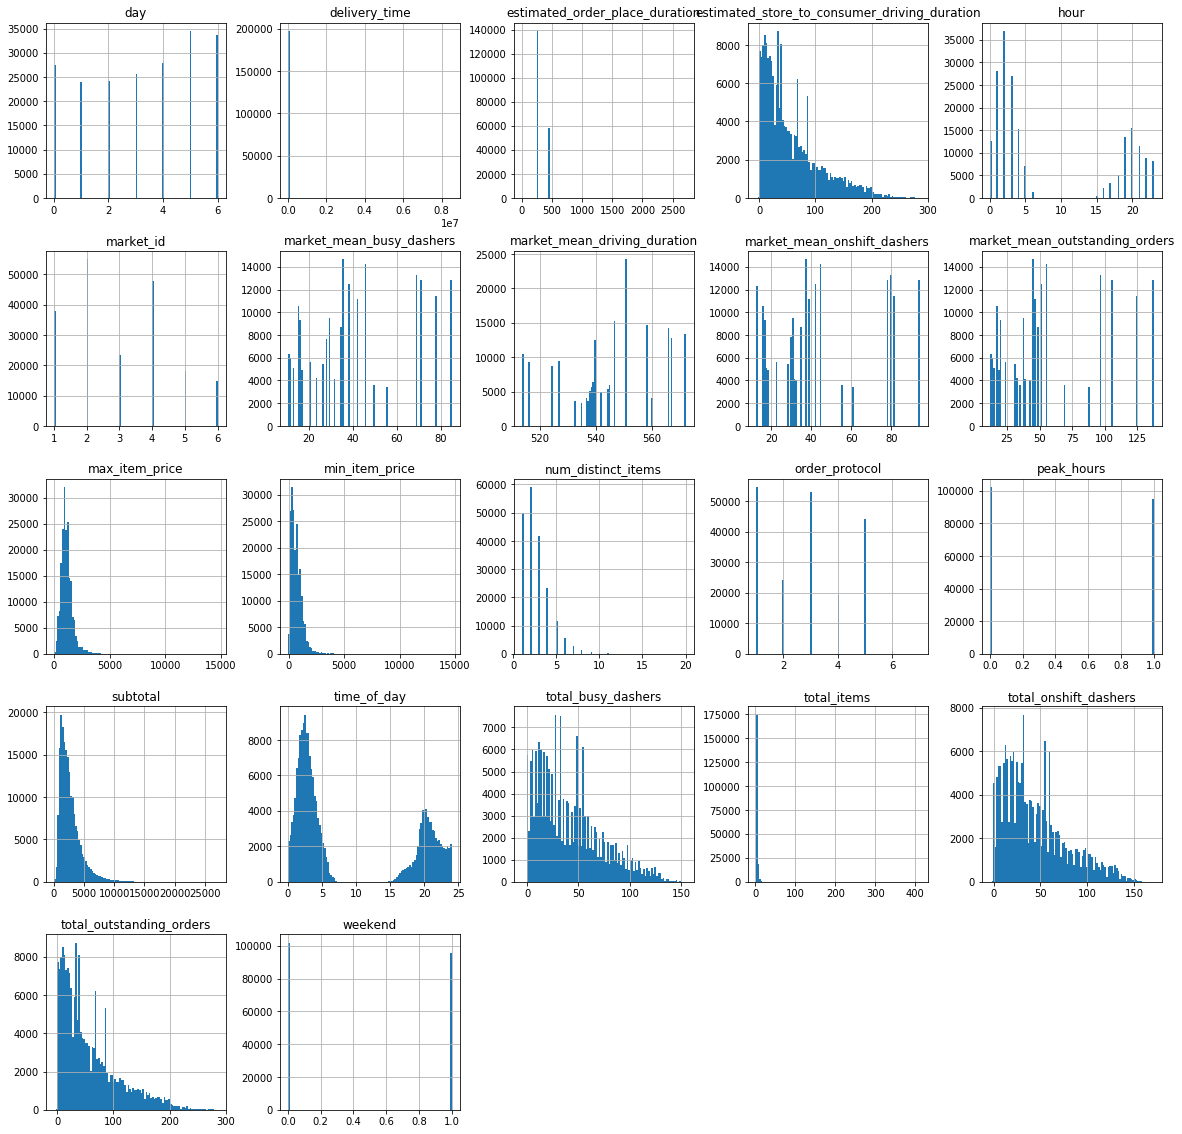

In [19]:
hist_data.hist( bins=100,figsize=(20, 20))

Next, we fill in the missing store_primary_category values. We group the historic data by store_primary_category and calculate the mean delivery times. For the rows that have missing store_primary_category values, we assign them the store_primary_category which is closest in terms of mean delivery time. If we also had the duration data in which the prepared meal is waiting to be picked up by the dasher in our dataset, we could've calculated approximate meal prep time for each order by subtracting the (wait time+driving time) from the delivery time. Meal prep time would've been an even more accurate choice to assign cuisine type to missing rows, as certain cuisines have a longer preparation time than others. We can also setup a nearest neighbors model based on other store features(if available) to determine store category. However, for the missing store category values in the test dataset(in part 2), we fill in the category with the most deliveries in that market. 

In [20]:
delivery_time_by_store_category=hist_data.groupby(['store_primary_category'],as_index=False).agg({'delivery_time':'mean'})
delivery_time_by_store_category=delivery_time_by_store_category.rename(index=str,columns={"delivery_time": "store_category_delivery_time"})
delivery_time_by_store_category.to_csv('delivery_time_by_store_category.csv')

In [21]:
delivery_time_by_store_category.to_csv('mean_delivery_time_by_store_category.csv')
delivery_time_by_store_category.sort_values('store_category_delivery_time',ascending=False)


,store_primary_category,store_category_delivery_time
39,italian,4212.391335
65,spanish,3370.702703
17,caribbean,3365.897233
9,brazilian,3358.377419
8,belgian,3299.500000
68,tapas,3255.034247
16,cajun,3150.053797
45,malaysian,3137.411765
40,japanese,3124.655030
0,afghan,3099.789916


As we can see here, mean delivery times vary a lot between cuisines. 

In [22]:
delivery_time_by_store_category_np=delivery_time_by_store_category.values
number_of_categories=len(delivery_time_by_store_category_np)
def replace_missing_store_category(x):
    if (pd.isnull(x['store_primary_category'])):
        distance=np.zeros(number_of_categories)
        for i in range(number_of_categories):
            distance[i]=abs(delivery_time_by_store_category_np[i][1]-x['delivery_time'])
        return delivery_time_by_store_category_np[np.argmin(distance)][0]  
    else:
        return x['store_primary_category']

In [23]:
hist_data['store_primary_category']=hist_data.apply(replace_missing_store_category,axis=1)


To fill in missing values for Order Protocol, we randomly sample values from the Order Protocol column from the rest of the data.

In [24]:
delivery_time_by_order_protocol=hist_data.groupby(['order_protocol'],as_index=False).agg({'delivery_time':['median','count','std']})
delivery_time_by_order_protocol=delivery_time_by_order_protocol.rename(index=str,columns={"delivery_time": "order_protocol_delivery_time"})

In [25]:
order_protocol_not_null=hist_data[hist_data['order_protocol'].notnull()]
def replace_missing_order_protocol(x):
    if np.isnan(x['order_protocol']):
        return int(order_protocol_not_null['order_protocol'].sample(1))
    else:
        return x['order_protocol']    
hist_data['order_protocol']=hist_data.apply(replace_missing_order_protocol,axis=1)


With no more missing values, we remove some extreme outliers in the data. For example, negative values for dasher numbers. We also restrict the delivery_time target to be no more than 3 hours so that the learning algorithm isn't influenced too much by outliers. 

In [26]:
hist_data_clean=hist_data[hist_data['delivery_time']<10800]


In [27]:
column_names_negative=['min_item_price','total_onshift_dashers','total_busy_dashers','total_outstanding_orders']
for col in column_names_negative:
    hist_data_clean=hist_data_clean[hist_data_clean[col]>=0]
    
hist_data_clean=hist_data_clean[hist_data_clean['total_items']<100]
hist_data_clean=hist_data_clean[hist_data_clean['subtotal']<15000]
hist_data_clean=hist_data_clean[hist_data_clean['min_item_price']<4000]
hist_data_clean=hist_data_clean[hist_data_clean['max_item_price']<8000]
hist_data_clean=hist_data_clean[hist_data_clean['estimated_order_place_duration']<1000]    

196821

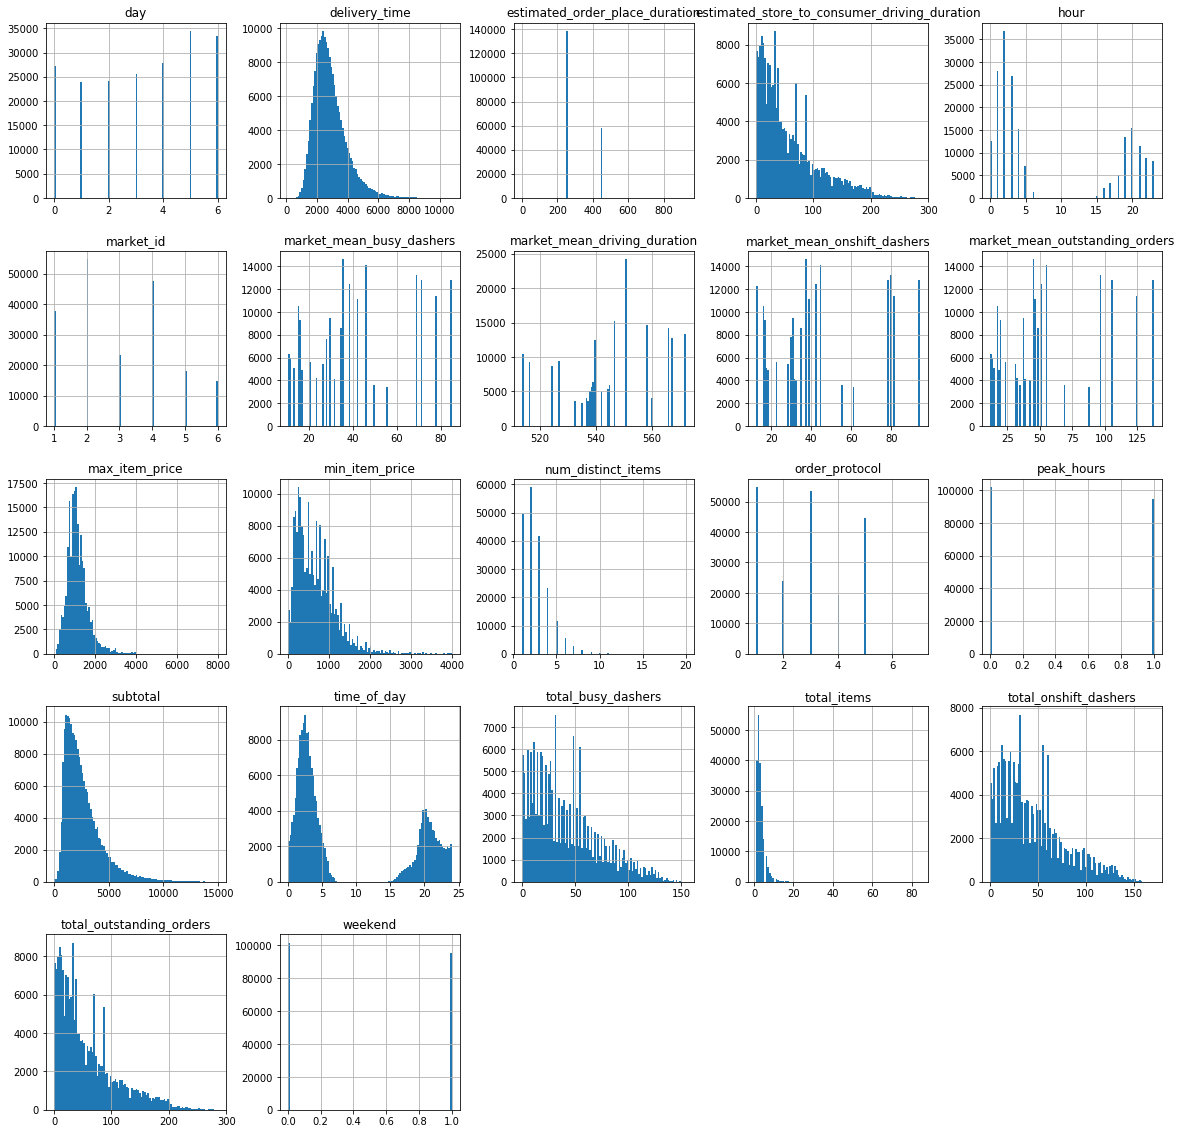

In [28]:
hist_data_clean.hist( bins=100,figsize=(20, 20))
len(hist_data_clean)

# Feature Engineering

Historical Features

We define some aggregate historical features based on mean values aggregated over market,store,cuisine and hour. 

In [29]:
mean_market_delivery_time = hist_data_clean.groupby('market_id',as_index=False).agg({'delivery_time':'mean'})
mean_market_delivery_time= mean_market_delivery_time.rename(index=str, columns={"delivery_time": "mean_market_delivery_time"})
              
mean_store_delivery_time = hist_data_clean.groupby('store_id',as_index=False).agg({'delivery_time':'mean'})
mean_store_delivery_time= mean_store_delivery_time.rename(index=str, columns={"delivery_time": "mean_store_delivery_time"})

mean_cuisine_delivery_time=hist_data_clean.groupby('store_primary_category',as_index=False).agg({'delivery_time':'mean'})
mean_cuisine_delivery_time= mean_cuisine_delivery_time.rename(index=str, columns={"delivery_time": "mean_cuisine_delivery_time"})
    
mean_hour_delivery_time=hist_data_clean.groupby('hour',as_index=False).agg({'delivery_time':'mean'})
mean_hour_delivery_time = mean_hour_delivery_time.rename(index=str, columns={"delivery_time": "mean_hour_delivery_time"})

hist_data_new_features=pd.merge(hist_data_clean, mean_market_delivery_time, on='market_id')
hist_data_new_features=pd.merge(hist_data_new_features, mean_store_delivery_time, on='store_id')
hist_data_new_features=pd.merge(hist_data_new_features, mean_cuisine_delivery_time, on='store_primary_category')
hist_data_new_features=pd.merge(hist_data_new_features, mean_hour_delivery_time, on='hour')



Saving the historical aggregates to file for generating features on the test data. 

In [30]:
mean_market_delivery_time.to_csv('mean_market_delivery_time.csv',index=False)
mean_cuisine_delivery_time.to_csv('mean_cuisine_delivery_time.csv',index=False)
mean_hour_delivery_time.to_csv('mean_hour_delivery_time.csv',index=False)
mean_store_delivery_time.to_csv('mean_store_delivery_time.csv',index=False)


We use the following features for training the prediction model. 

In [31]:
feature_names=['min_item_price',
               'max_item_price','total_items',
               'subtotal','num_distinct_items','total_onshift_dashers',
               'total_busy_dashers','total_outstanding_orders','estimated_order_place_duration',
               'estimated_store_to_consumer_driving_duration','mean_market_delivery_time',
                'mean_store_delivery_time','mean_cuisine_delivery_time','mean_hour_delivery_time']


We use One Hot Encoding on the categorical features.

In [32]:
hour_features=pd.get_dummies(hist_data_new_features['hour'],prefix='hour')
day_features=pd.get_dummies(hist_data_new_features['day'],prefix='day')
market_id_features=pd.get_dummies(hist_data_new_features['market_id'],prefix='market_id')
order_protocol_features=pd.get_dummies(hist_data_new_features['order_protocol'],prefix='order_protocol')



We generate the full feature list, create the training and target datasets and split them for a 10-fold cross-validation

In [33]:
all_features=feature_names+list(market_id_features.columns.values)+list(order_protocol_features.columns.values)+list(hour_features.columns.values)+list(day_features.columns.values)
training_dataframe=pd.concat([hist_data_new_features,market_id_features,order_protocol_features,hour_features,day_features],axis=1)
hist_data_subset_X=training_dataframe[all_features].values
hist_data_subset_Y=training_dataframe['delivery_time'].values
num_splits=10
kf = sk.model_selection.KFold(n_splits=num_splits)

# Building Learning Models

Defining a function to plot a learning curve and another to train, perform 10-fold cross validation and print the mean rmse error. After training on each cross-validation set, we plot the residual distribution and print its mean and SD. Their means should be close to zero.

In [34]:
def learning_curve(model,X,y):
    train_sizes, train_scores, test_scores=sk.model_selection.learning_curve(model, X, y,cv=5,scoring='neg_mean_squared_error')
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Draw lines
    plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    # Create plot
    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

In [35]:
def train_cross_validate(model,X,y):
    fit_models=[]
    avg_error=0
    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if model is not None:
            model.fit(X_train, y_train)

            fit_models.append(model)
            #print(model.feature_importances_)
            #print(model.coef_)
            
            y_predicted=model.predict(X_test)
        else:
            y_predicted=np.ones(len(y_test))*[np.mean(y_train)]
            
        
        n, bins, patches = plt.hist(y_predicted- y_test, 100, normed=0, alpha=0.75)
        plt.show()
        error=math.sqrt(np.mean((y_predicted- y_test) ** 2))
        print("Mean Residual: %.2f"
          % np.mean(y_predicted- y_test))
        print("Residual SD: %.2f"
          % np.std((y_predicted- y_test)))
        print("RMSE: %.2f"
          % error)
        avg_error=avg_error+error
    avg_error=avg_error/num_splits   
    print avg_error

Let's take a look at the performance of a very basic model which predicts the mean delivery time of the training dataset for each test dataset row.

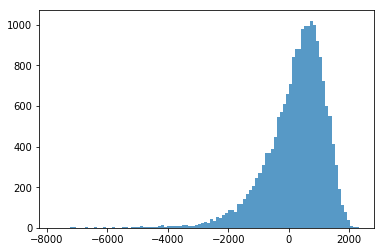

Mean Residual: 224.16
Residual SD: 1000.15
RMSE: 1024.96


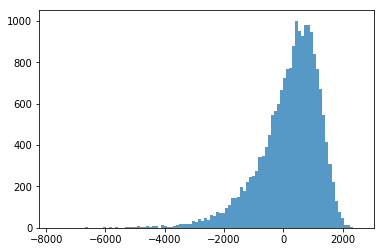

Mean Residual: 195.23
Residual SD: 1034.17
RMSE: 1052.43


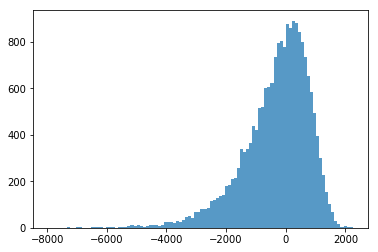

Mean Residual: -327.10
Residual SD: 1132.74
RMSE: 1179.02


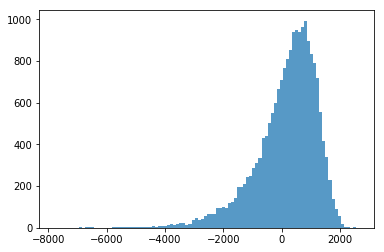

Mean Residual: 146.27
Residual SD: 1070.02
RMSE: 1079.97


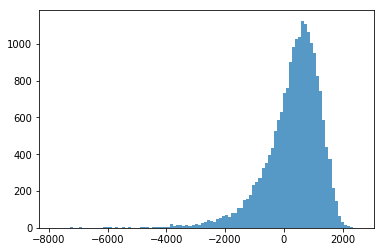

Mean Residual: 304.19
Residual SD: 958.08
RMSE: 1005.21


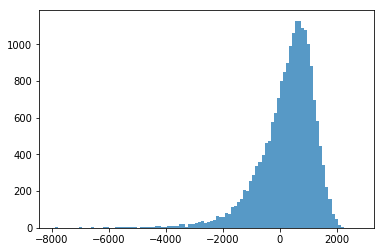

Mean Residual: 251.21
Residual SD: 987.36
RMSE: 1018.82


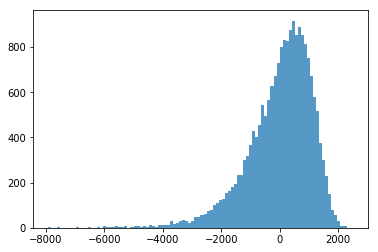

Mean Residual: 6.98
Residual SD: 1111.14
RMSE: 1111.16


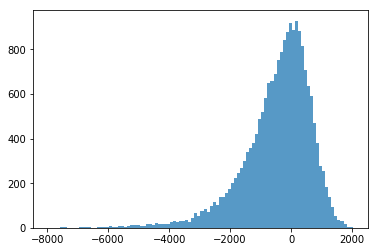

Mean Residual: -463.37
Residual SD: 1126.47
RMSE: 1218.05


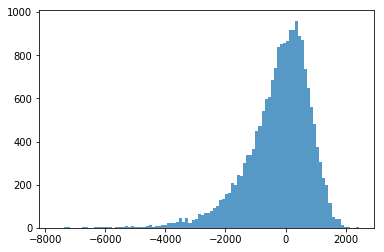

Mean Residual: -249.55
Residual SD: 1084.27
RMSE: 1112.62


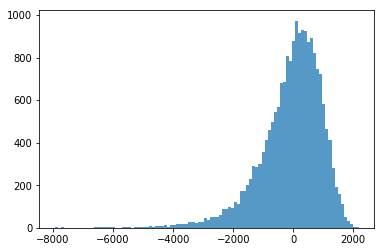

Mean Residual: -88.02
Residual SD: 1053.55
RMSE: 1057.22
1085.94701995


In [36]:
train_cross_validate(None,hist_data_subset_X,hist_data_subset_Y)

Mean residuals vary a lot and are not centered around zero. The mean RMSE is more than 1000s. Let's try Linear Regression next.

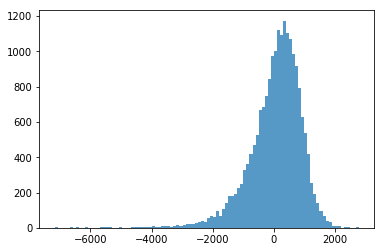

Mean Residual: 47.49
Residual SD: 860.03
RMSE: 861.34


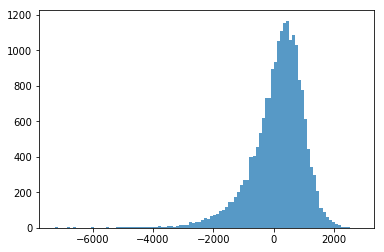

Mean Residual: 128.75
Residual SD: 886.02
RMSE: 895.33


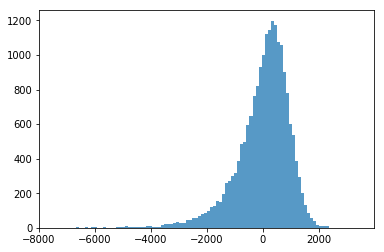

Mean Residual: 0.68
Residual SD: 953.49
RMSE: 953.49


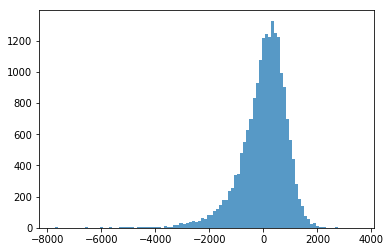

Mean Residual: 4.58
Residual SD: 870.06
RMSE: 870.07


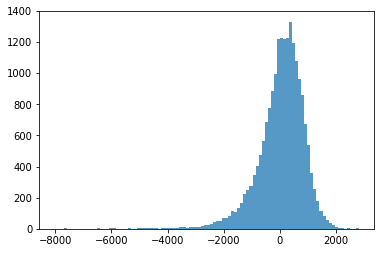

Mean Residual: 44.11
Residual SD: 834.10
RMSE: 835.26


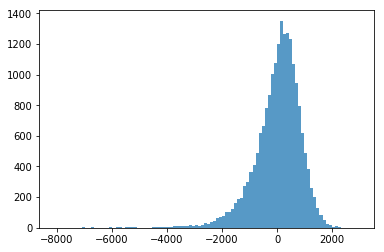

Mean Residual: 15.57
Residual SD: 859.94
RMSE: 860.08


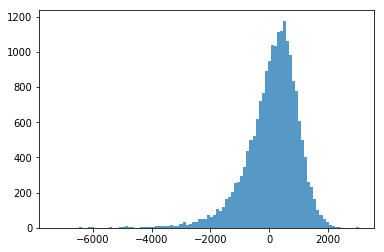

Mean Residual: 98.69
Residual SD: 899.80
RMSE: 905.20


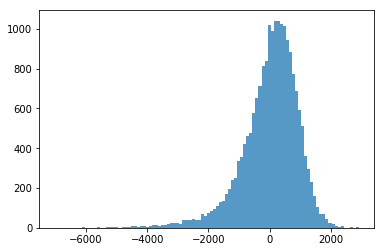

Mean Residual: 6.82
Residual SD: 938.12
RMSE: 938.15


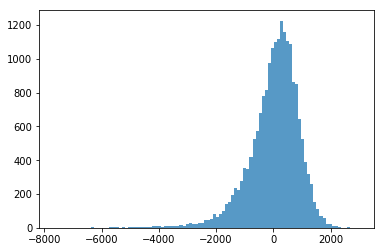

Mean Residual: 12.36
Residual SD: 896.17
RMSE: 896.26


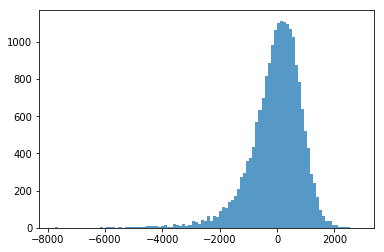

Mean Residual: -41.96
Residual SD: 908.45
RMSE: 909.42
892.460235972


In [37]:
ridge_reg = sk.linear_model.Ridge(alpha=0.005,fit_intercept=True, normalize=True)
train_cross_validate(ridge_reg,hist_data_subset_X,hist_data_subset_Y)
#learning_curve(ridge_reg,hist_data_subset_X,hist_data_subset_Y)

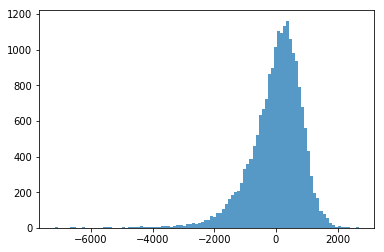

Mean Residual: -0.80
Residual SD: 858.25
RMSE: 858.25


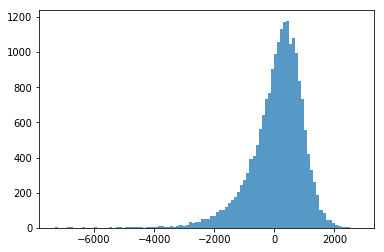

Mean Residual: 85.88
Residual SD: 884.69
RMSE: 888.85


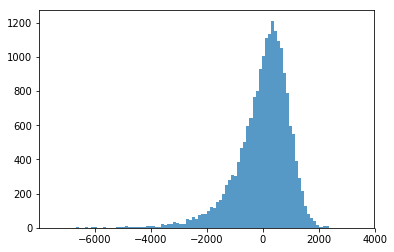

Mean Residual: 11.57
Residual SD: 953.80
RMSE: 953.87


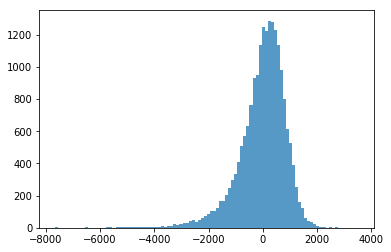

Mean Residual: -24.98
Residual SD: 869.87
RMSE: 870.23


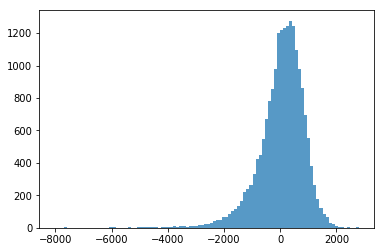

Mean Residual: 35.51
Residual SD: 833.32
RMSE: 834.07


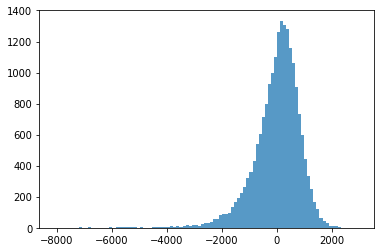

Mean Residual: -9.17
Residual SD: 858.45
RMSE: 858.50


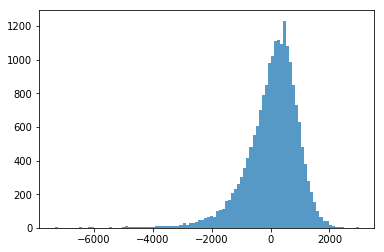

Mean Residual: 54.58
Residual SD: 893.53
RMSE: 895.20


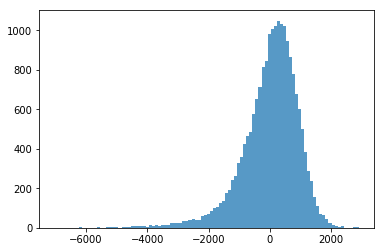

Mean Residual: 1.73
Residual SD: 938.79
RMSE: 938.79


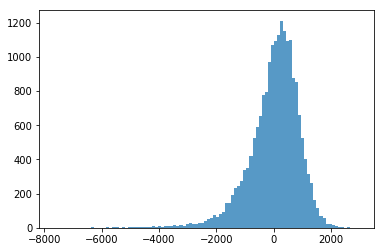

Mean Residual: 7.04
Residual SD: 896.47
RMSE: 896.49


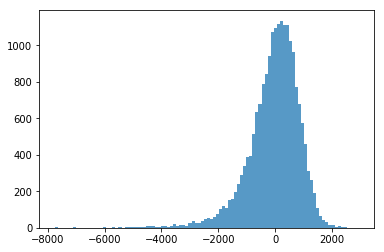

Mean Residual: -45.26
Residual SD: 907.82
RMSE: 908.95
890.319648081


In [38]:
lasso_reg = sk.linear_model.Lasso(alpha = 0.005,fit_intercept=True,normalize=True)
train_cross_validate(lasso_reg,hist_data_subset_X,hist_data_subset_Y)

Let's try a Random Forest Model.

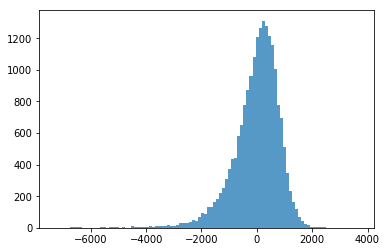

Mean Residual: -28.70
Residual SD: 856.87
RMSE: 857.35


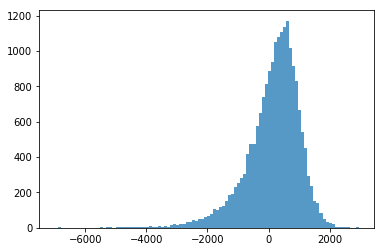

Mean Residual: 140.66
Residual SD: 898.41
RMSE: 909.35


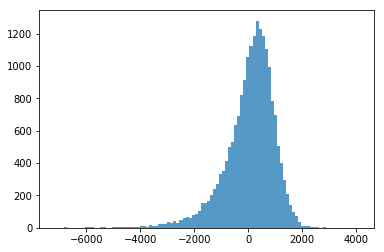

Mean Residual: 49.14
Residual SD: 932.10
RMSE: 933.39


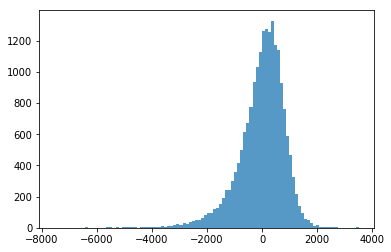

Mean Residual: -20.72
Residual SD: 855.26
RMSE: 855.51


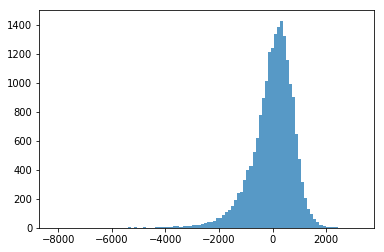

Mean Residual: -8.38
Residual SD: 823.83
RMSE: 823.87


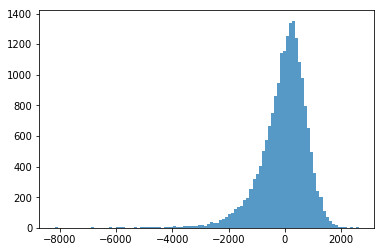

Mean Residual: -46.62
Residual SD: 849.95
RMSE: 851.23


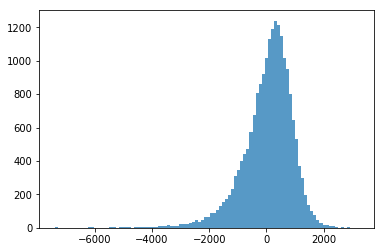

Mean Residual: 47.22
Residual SD: 875.45
RMSE: 876.72


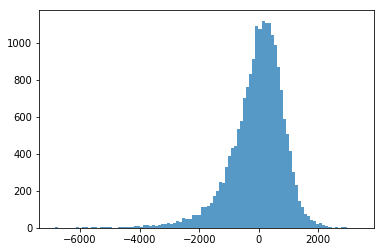

Mean Residual: -54.20
Residual SD: 911.75
RMSE: 913.36


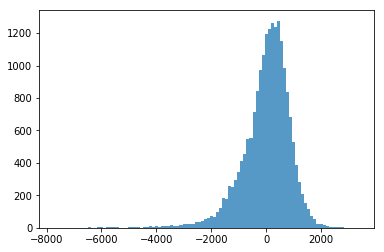

Mean Residual: 0.25
Residual SD: 880.04
RMSE: 880.04


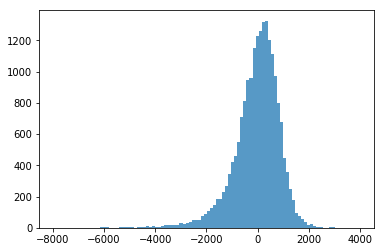

Mean Residual: -43.54
Residual SD: 903.73
RMSE: 904.78
880.560125373


In [63]:
rf=sk.ensemble.RandomForestRegressor(n_estimators=50, oob_score=True, n_jobs = -1, random_state=42,criterion= 'mse', max_features = 'auto', min_samples_leaf = 20)
train_cross_validate(rf,hist_data_subset_X,hist_data_subset_Y)

Training a Gradient Boosted Regression Tree using the XGBoost Library.

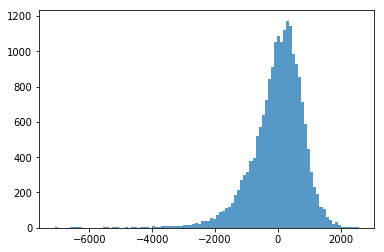

Mean Residual: -20.18
Residual SD: 843.76
RMSE: 844.00


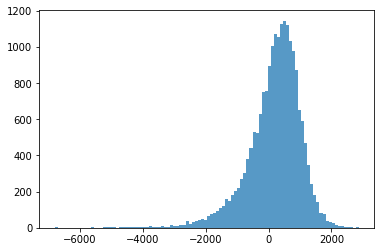

Mean Residual: 176.65
Residual SD: 858.94
RMSE: 876.92


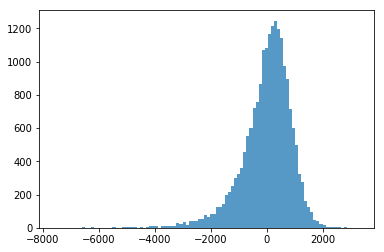

Mean Residual: -11.45
Residual SD: 893.70
RMSE: 893.77


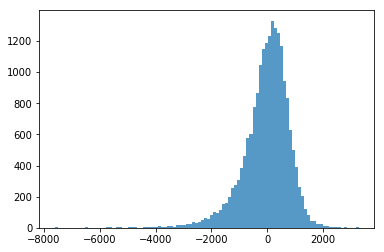

Mean Residual: -42.47
Residual SD: 834.82
RMSE: 835.90


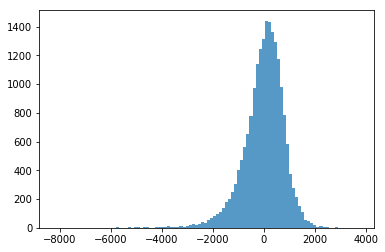

Mean Residual: -24.19
Residual SD: 824.21
RMSE: 824.57


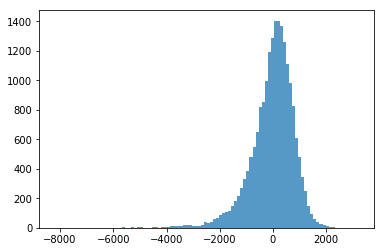

Mean Residual: -31.86
Residual SD: 836.32
RMSE: 836.93


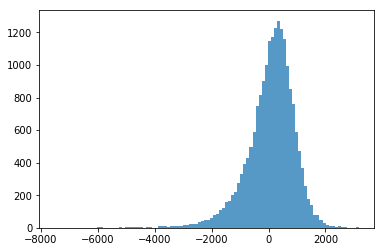

Mean Residual: 72.95
Residual SD: 851.36
RMSE: 854.48


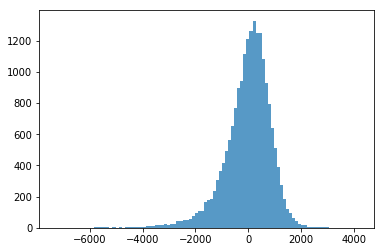

Mean Residual: -23.52
Residual SD: 889.13
RMSE: 889.44


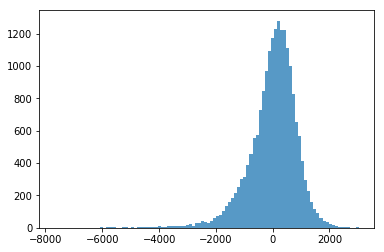

Mean Residual: 1.02
Residual SD: 858.25
RMSE: 858.25


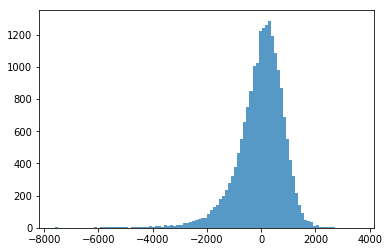

Mean Residual: -35.00
Residual SD: 885.30
RMSE: 886.00
860.024914758


In [85]:
xgb_reg = xgb.XGBRegressor(learning_rate= 0.1, max_depth=5,n_estimators= 500, seed=10, subsample=0.8, colsample_bytree= 0.6, 
             eval_metric='rmse',min_child_weight=1,booster='gbtree',gamma= 0.1,reg_alpha=0.1,reg_lambda= 1,n_rounds=30,n_jobs=-1)
train_cross_validate(xgb_reg,hist_data_subset_X,hist_data_subset_Y)

# Evaluating models using learning curves

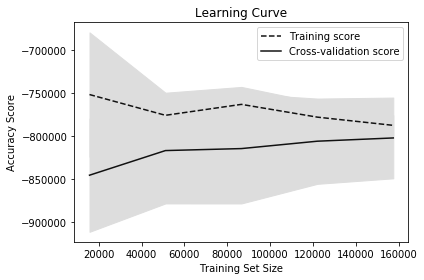

In [64]:
learning_curve(ridge_reg,hist_data_subset_X,hist_data_subset_Y)

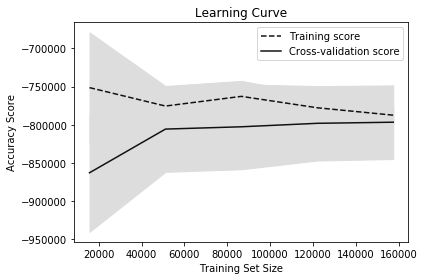

In [65]:
learning_curve(lasso_reg,hist_data_subset_X,hist_data_subset_Y)

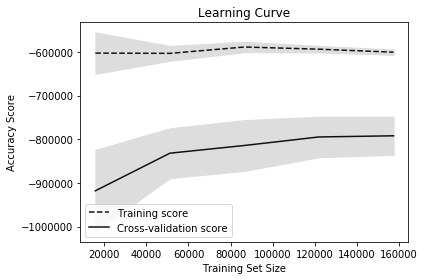

In [66]:
learning_curve(rf,hist_data_subset_X,hist_data_subset_Y)

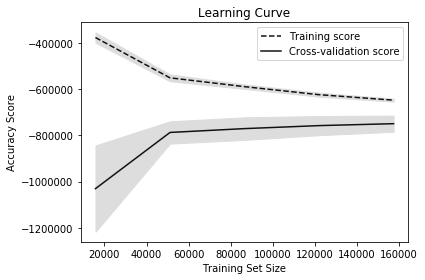

In [84]:
learning_curve(xgb_reg,hist_data_subset_X,hist_data_subset_Y)
#5

# Optimizing hyper-parameters


In [ ]:
parameters = {'learning_rate': [0.1,0.3], 'max_depth' : [5,7,9,15],'n_estimators' : [500,700,900], 'seed': [10], 'subsample' : [0.6,0.8], 'colsample_bytree' : [0.6,0.8], 
             'eval_metric': ['rmse'],'min_child_weight':[1],'booster':['gbtree'],'gamma':[0.1,0.3,0.5],'reg_alpha': [0.1],'reg_lambda': [0,0.1,1],'n_rounds':[30]}
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=parameters, cv=5, n_jobs=-1,verbose=5)
    
grid_search.fit(hist_data_subset_X, hist_data_subset_Y)
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters=grid_search.best_estimator_.get_params()
print best_parameters

In [ ]:
xgb_reg=xgb.XGBRegressor(best_parameters)

In [87]:
xgb_reg.fit(training_dataframe[all_features],training_dataframe['delivery_time'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, eval_metric='rmse', gamma=0.1,
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
       n_rounds=30, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.1, reg_lambda=1, scale_pos_weight=1, seed=10,
       silent=True, subsample=0.8)

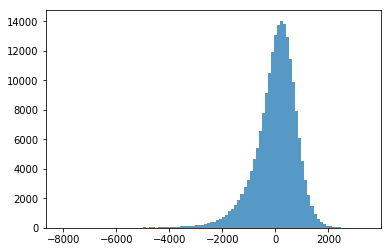

Mean Residual: 0.14
Residual SD: 811.57
RMSE: 811.57


In [89]:
y_predicted=xgb_reg.predict(training_dataframe[all_features])
y_train=training_dataframe['delivery_time'].values

n, bins, patches = plt.hist(y_predicted- y_train, 100, normed=0, alpha=0.75)
plt.show()
error=math.sqrt(np.mean((y_predicted- y_train) ** 2))
print("Mean Residual: %.2f"
      % np.mean(y_predicted- y_train))
print("Residual SD: %.2f"
      % np.std((y_predicted- y_train)))
print("RMSE: %.2f"
      % error)

Historical Data Mean: 2851.52
Historical Data SD: 1082.23


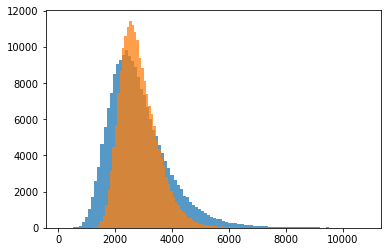

Predicted Mean: 2851.66
Predicted SD: 675.63


In [94]:
n, bins, patches = plt.hist(y_train, 100, normed=0, alpha=0.75)
#plt.show()

print("Historical Data Mean: %.2f"
      % np.mean(y_train))
print("Historical Data SD: %.2f"
      % np.std((y_train)))

n, bins, patches = plt.hist(y_predicted, 100, normed=0, alpha=0.75)
plt.show()

print("Predicted Mean: %.2f"
      % np.mean(y_predicted))
print("Predicted SD: %.2f"
      % np.std((y_predicted)))

In [95]:
pickle.dump(xgb_reg, open("XGBR.dat", "wb"))

# Model Insights

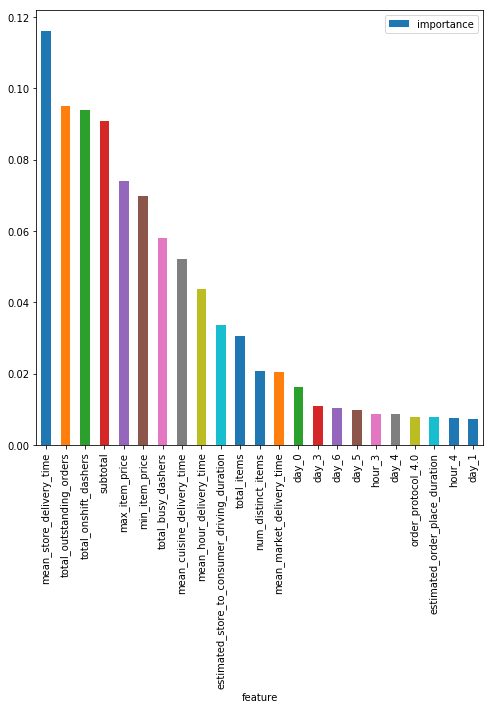

In [110]:
feature_importance_xgb=pd.DataFrame(columns=['feature','importance'])
feature_importance_xgb['feature']=all_features
feature_importance_xgb['importance']=xgb_reg.feature_importances_
feature_importance_xgb=feature_importance_xgb.sort_values('importance',ascending=False)
feature_importance_xgb[feature_importance_xgb['importance']>0.007].plot.bar('feature','importance',figsize=(8,8))


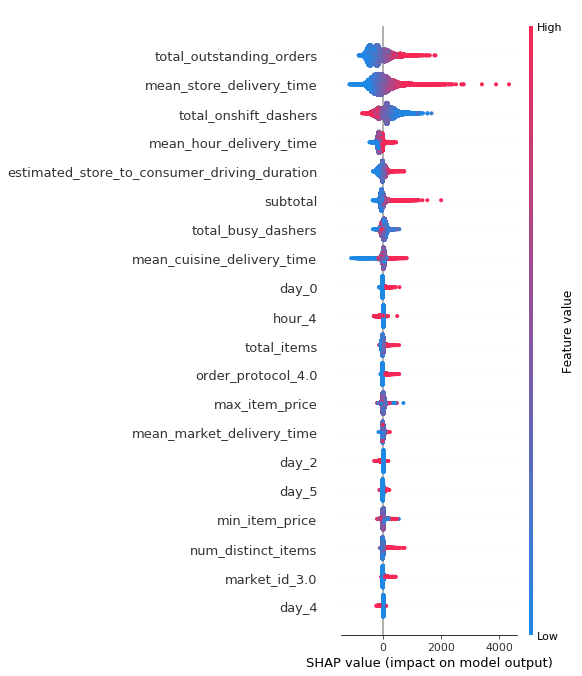

In [73]:
shap.initjs() 
shap_values = shap.TreeExplainer(xgb_reg).shap_values(training_dataframe[all_features][1:40000])
shap.summary_plot(shap_values, training_dataframe[all_features][1:40000])

We use the SHAP library(https://github.com/slundberg/shap) "to get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low)." This reveals for example that a high total_outstanding_orders increases the predicted delivery time.

# Recommendations

* Looking at the feature importance values, historical mean_store_delivery_time ranks very high. Stores which have historically had long delivery times should be taken into special consideration. Maybe the store is slightly far from where the orders come from. Or maybe dashers struggle to find parking at the store. Maybe the store is busier than other stores and take a longer time to prepare foods. Indentifying causes for stores with high mean_store_delivery_time can help reduce delivery times for these stores significantly.

* Total_onshift_dashers and total_outstanding_orders are among the most influential factors. We can increase the number of onshift dashers by incentivizing dashers when total_outstanding_orders values exceeds a certain threshold and ensure that the number of onshift dashers remains high. 

* Subtotal has a strong influence on delivery times. Higher sub totals lead to higher delivery times. We can tweak the dispatch algorithm to ensure that the dasher always arrives slightly earlier when subtotal is higher than historical thresholds. So, there is no additional wait time (the food waits for a dasher to be picked up). 

* Total items and number of distinct items have a similar effect on delivery time. We can adopt a similar strategy flagging orders which have too many items and prioritizing them for dasher dispatch over others.

* As expected day0(Sunday) and day6(Saturday) affect the delivery time the strongest. day3(Wednesday) ranks next and is as high as the day05(Friday). Getting more dashers during weekends will help reduce the delivery times. Paying dashers more on these days could get more dashers available and may reduce the delivery times. Similarly, for hour3 and hour4.
